## 目的：计算EEG信号的近似熵、样本熵和模糊熵
### 衡量时间序列中产生新模式的概率的大小，产生新模式的概率越大，序列的复杂性也就越大。  
### 较高的熵值表示数据序列具有较高的复杂性和较低的可预测性。

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from scipy.signal import lfilter, medfilt
from matplotlib.patches import Rectangle

### 1. 定义熵函数

#### 1.1 近似熵

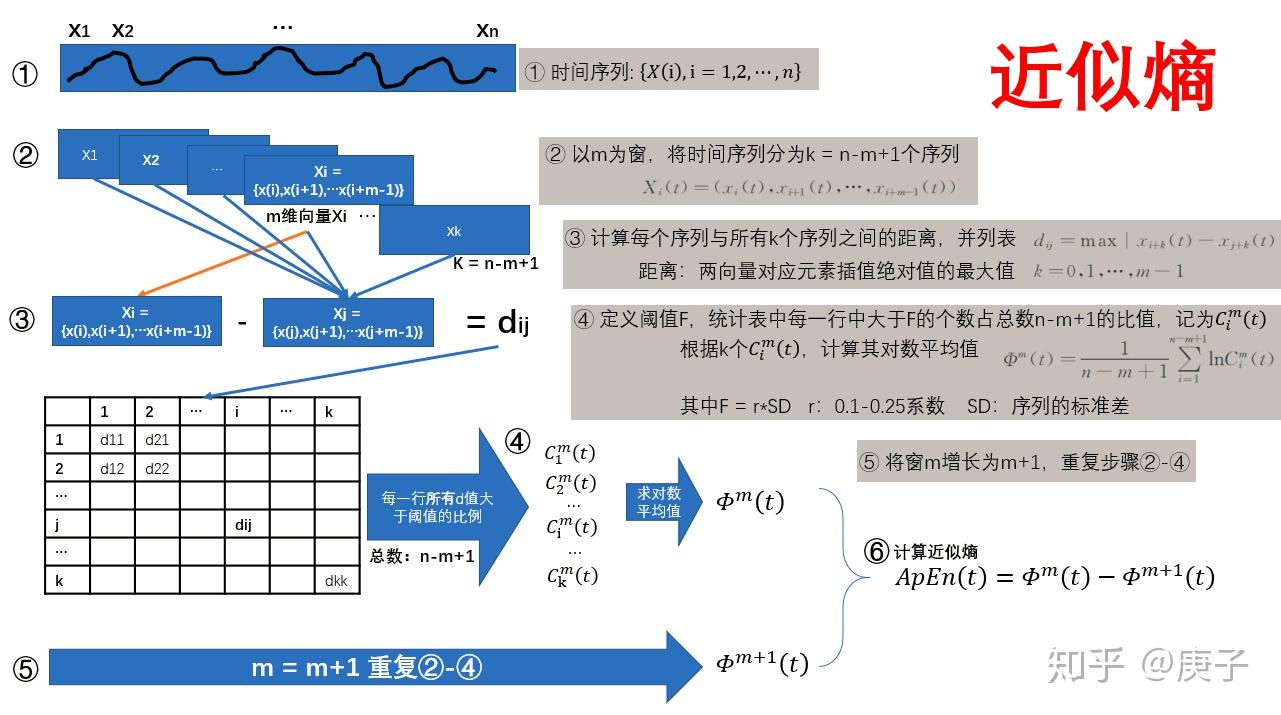

In [2]:
def ApEn(x, m, r):                                             # 2. m：模式维数， r：相似容限
    N = len(x)                                                      # 1. 信号总长N
    x = np.array(x)
    if x.ndim != 1:
        raise ValueError("x的维度不是一维")
    if N < m + 1:
        raise ValueError("len(x)小于m+1")  
        
    phi = []
    for temp in range(2):  # 7.	将窗 m 增长为 m+1: temp = 0：m ； temp = 1: m+1
        # 3. 以m为窗，将时间序列分为k = n-m+1个序列
        X = []
        m = m+temp
        for i in range(N + 1 - m):
            X.append(x[i:i+m])
        X = np.array(X)
        
        # 4. 计算每个i与所有j之间的绝对值距离，获取统计个数：N_m(i)【count】
        C = []
        for index1, i in enumerate(X):
            count = 0
            for index2, j in enumerate(X):
                if index1 != index2:
                    if np.max(np.abs(i-j)) <= r:
                        count += 1
            # 5. 获取 C
            C.append(count/(N-m+1))
        # 处理C为0的值，替换为一个非零的很小的数,以防取对数时报错
        C = np.array(C)
        C = np.where(C == 0, 1e-10, C)
        
        # 6. 对每个C取自然对数，获取 Φ
        phi.append(np.sum(np.log(C))/(N-m+1))
        
    # 8. 获取近似熵
    apEn = phi[0] - phi[1]
    return apEn

#### 1.2 样本熵

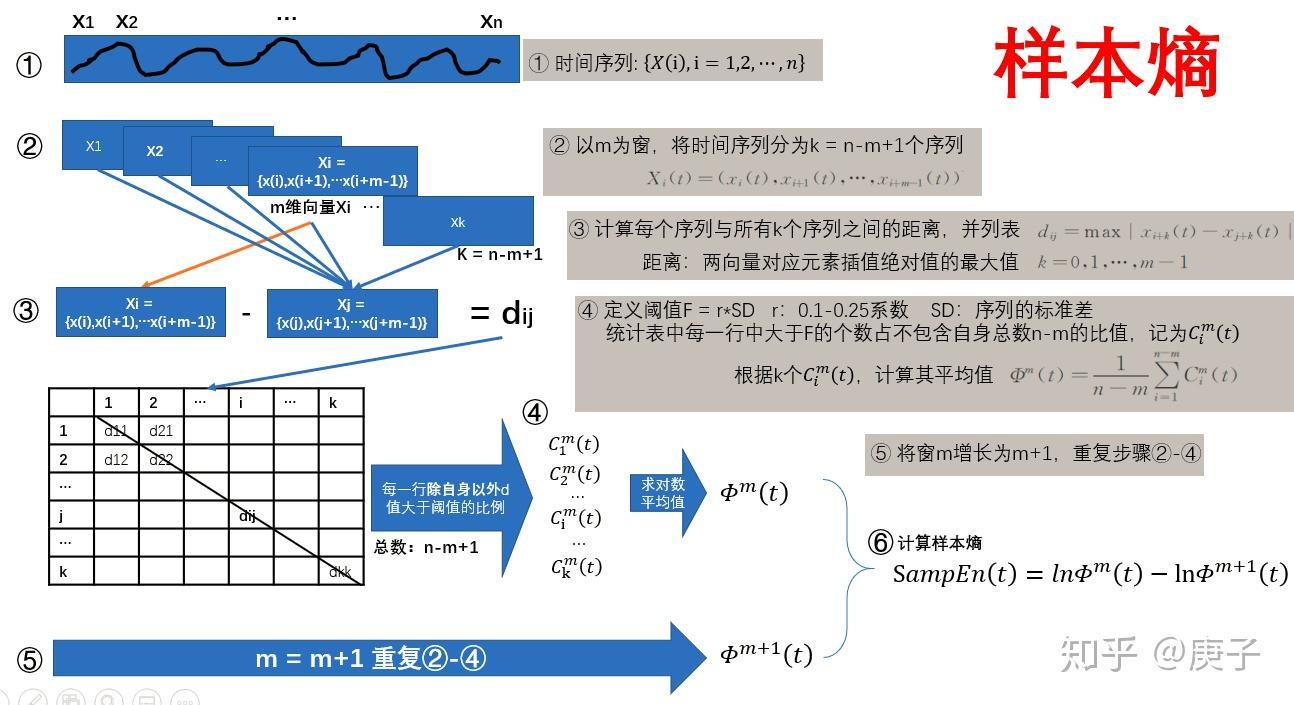

In [3]:
def SampEn(x, m, r):
    N = len(x)                                                      # 1. 信号总长N
    x = np.array(x)
    if x.ndim != 1:
        raise ValueError("x的维度不是一维")
    if N < m + 1:
        raise ValueError("len(x)小于m+1")  
        
    AB = []
    for temp in range(2):  # 7.	将窗 m 增长为 m+1: temp = 0：m ； temp = 1: m+1
        # 3. 以m为窗，将时间序列分为k = n-m+1个序列
        X = []
        m = m+temp
        for i in range(N + 1 - m):
            X.append(x[i:i+m])
        X = np.array(X)
        
        # 4. 计算每个i与所有j之间的绝对值距离，统计距离d小于r的个数：N_m(i)【count】
        C = []
        for index1, i in enumerate(X):
            count = 0
            for index2, j in enumerate(X):
                if index1 != index2:
                    if np.max(np.abs(i-j)) <= r:
                        count += 1
            # 5. 获取每个i的 C
            C.append(count/(N-m+1))
        # 处理C为0的值，替换为一个非零的很小的数,以防取对数时报错
        C = np.array(C)
        C = np.where(C == 0, 1e-10, C)
        
        # 6. 求所有i得平均值
        AB.append(np.sum(C)/(N-m+1))
        
    # 8. 获取样本熵
    SE = np.log(AB[0]) - np.log(AB[1])
    return SE

#### 1.3 模糊熵

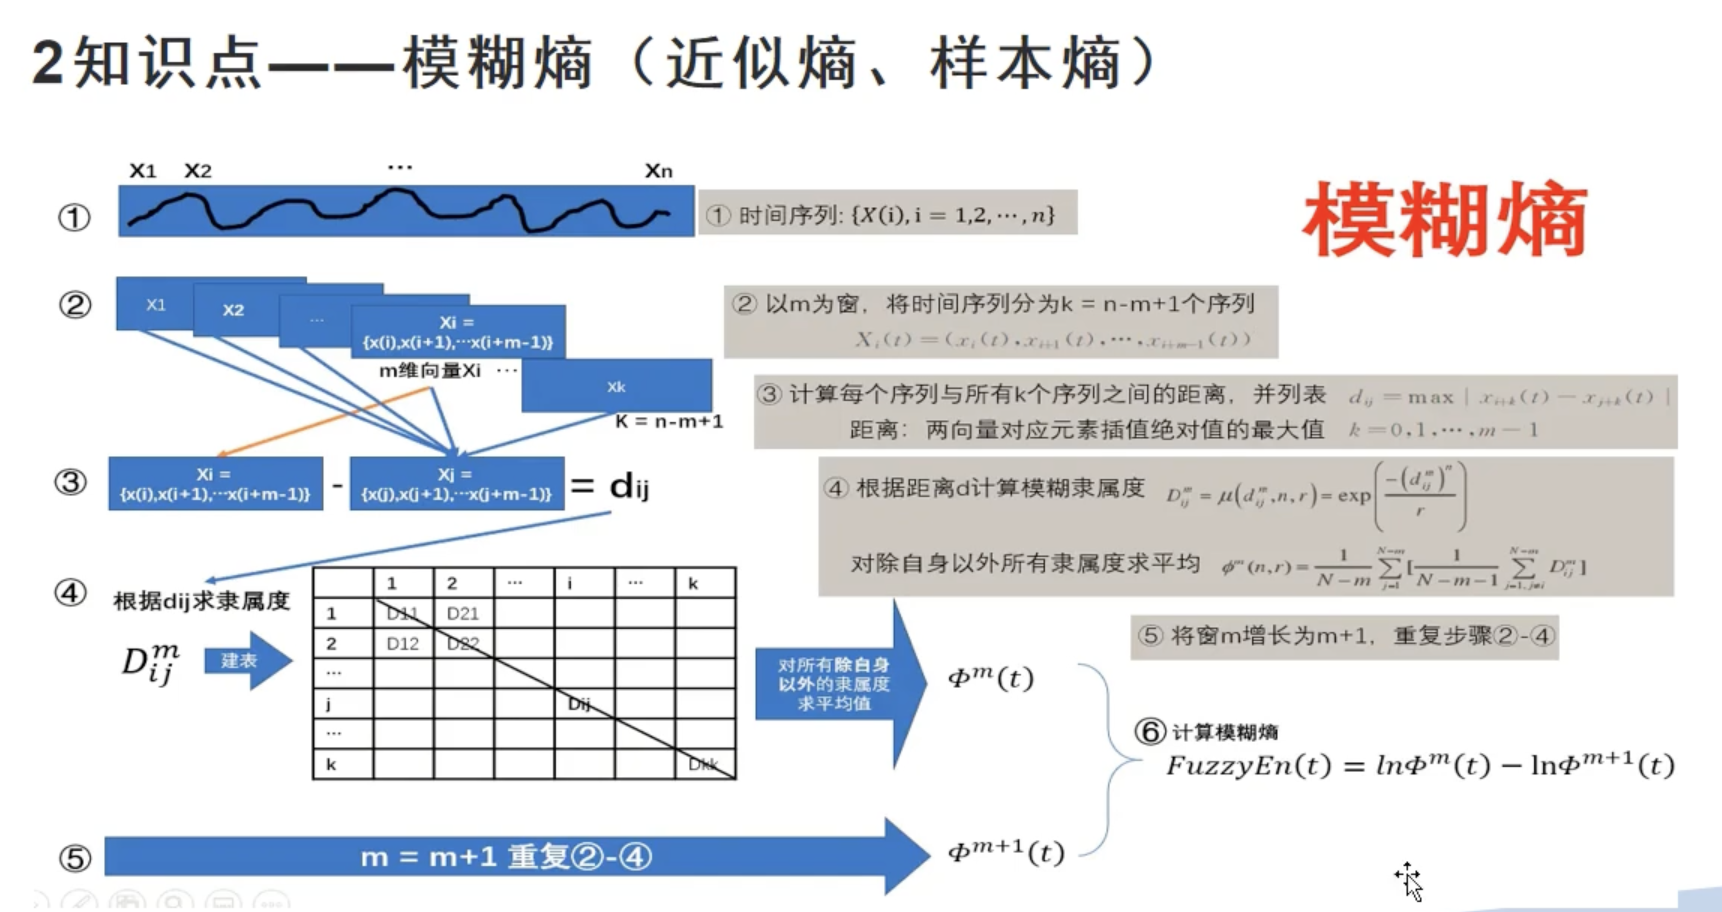

In [4]:
def FuzzyEntopy(x, m, r=0.15, n=2):
    x = np.array(x)
    if x.ndim != 1:
        raise ValueError("x的维度不是一维")
    if len(x) < m + 1:
        raise ValueError("len(x)小于m+1")  
    entropy = 0
    
    for temp in range(2):  # 5.	将窗 m 增长为 m+1: temp = 0：m ； temp = 1: m+1
        # 2. 以m为窗，将时间序列分为k = n-m+1个序列
        X = []
        for i in range(len(x) + 1 - (m  + temp)):
            X.append(x[i:i+m+temp])
        X = np.array(X)
        D_value = []
        # 3. 计算绝对距离
        for index1, i in enumerate(X):
            d = []
            for index2, j in enumerate(X):
                if index1 != index2:
                    d.append(np.max(np.abs(i-j)))
            D_value.append(d)
        # 4. 计算模糊隶属度D
        D = np.exp(-np.power(D_value, n)/r)
        Lm = np.average(D.ravel())
        # 6. 计算模糊熵
        entropy = np.abs(entropy) - np.log(Lm)
    return entropy

### 2. 构建EEG信号

#### 2.1 创建粉红噪声：粉红噪声的谱密度是随频率的增加而呈1/f衰减

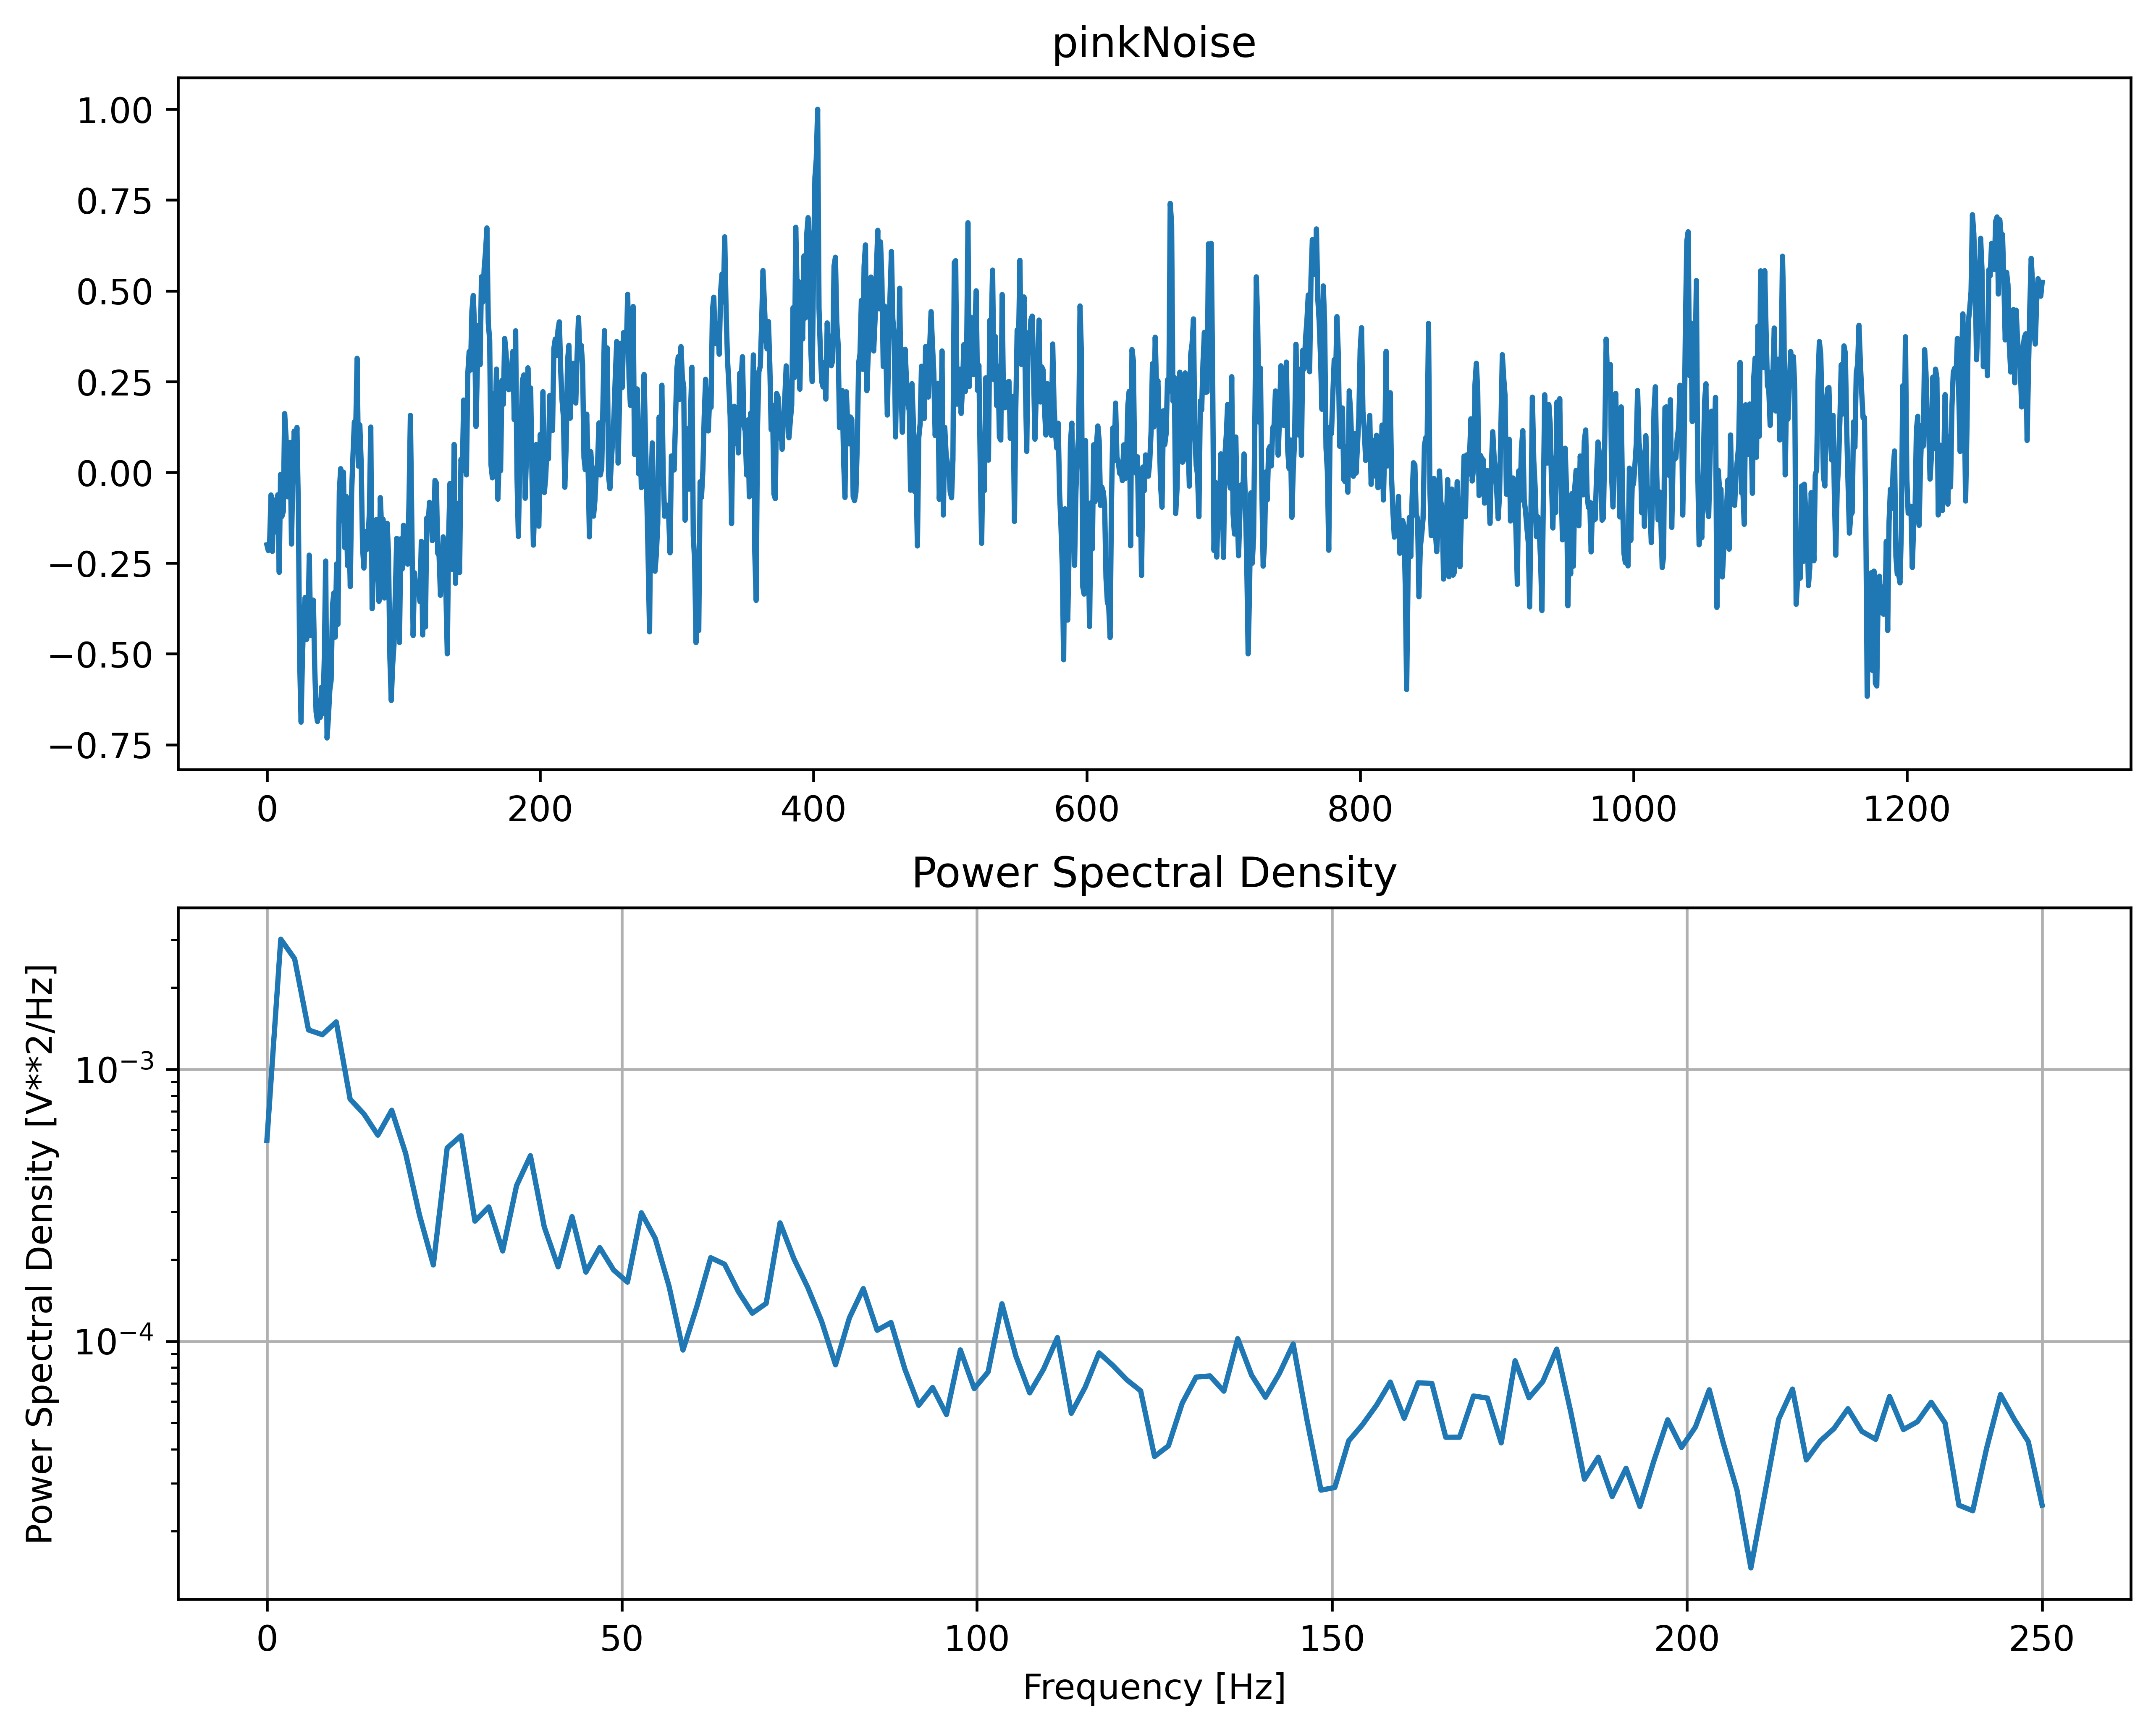

In [5]:
def generate_pink_noise(num_samples):
    # 创建白噪声
    white_noise = np.random.randn(num_samples)

    # 设置滤波器系数
    b = [0.049922035, -0.095993537, 0.050612699, -0.004408786]
    a = [1, -2.494956002, 2.017265875, -0.522189400]

    # 使用滤波器对白噪声进行滤波
    pink_noise = lfilter(b, a, white_noise)

    # 标准化粉红噪声的幅度范围
    pink_noise /= np.max(np.abs(pink_noise))

    return pink_noise
# 生成1000个样本的粉红噪声
pinkNoise = generate_pink_noise(1300)
# 绘制粉红噪声及其功率谱
plt.figure(figsize=(10,8), dpi = 600)
plt.subplot(2,1,1)
plt.plot(pinkNoise)
plt.title('pinkNoise')
# 计算信号的功率谱
f, Pxx = signal.welch(pinkNoise, 500)
plt.subplot(2,1,2)
plt.semilogy(f, Pxx)
plt.xlabel('Frequency [Hz]')
plt.ylabel('Power Spectral Density [V**2/Hz]')
plt.title('Power Spectral Density')
plt.grid(True)
plt.show()

#### 2.2 构建P300信号：在粉红噪声上添加汉明窗

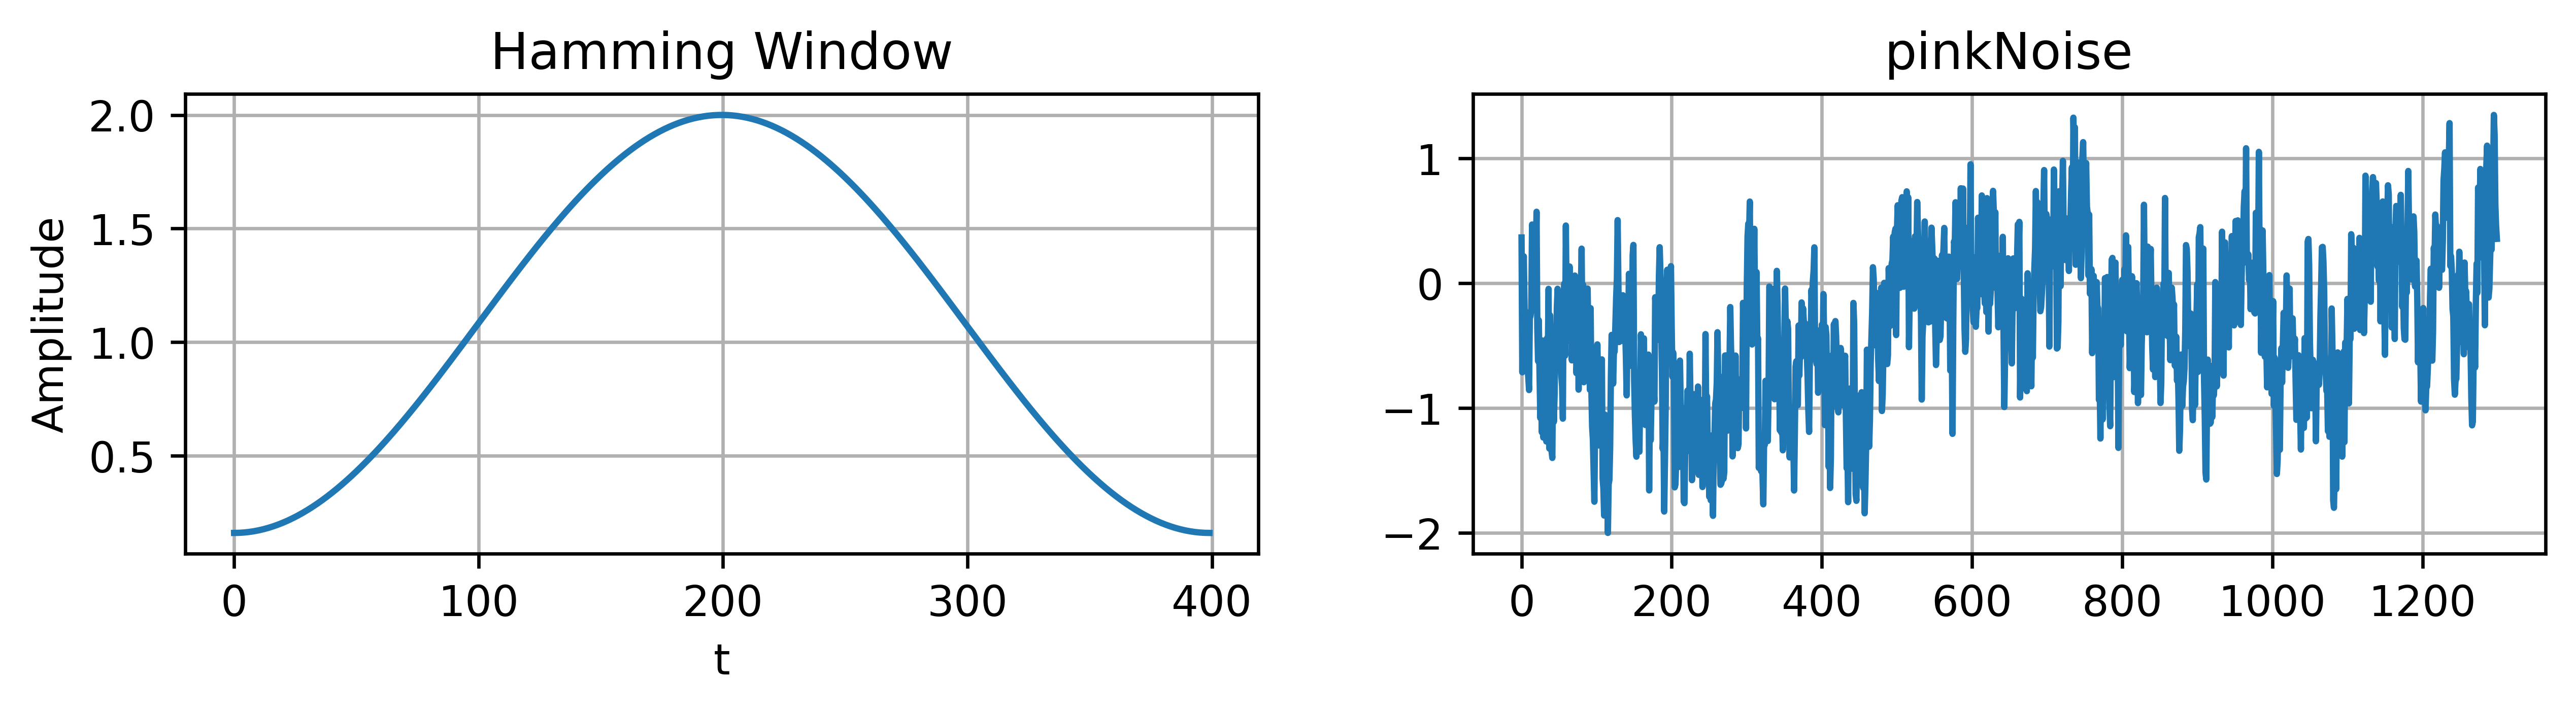

Text(0.5, 1.0, 'EEG_p300')

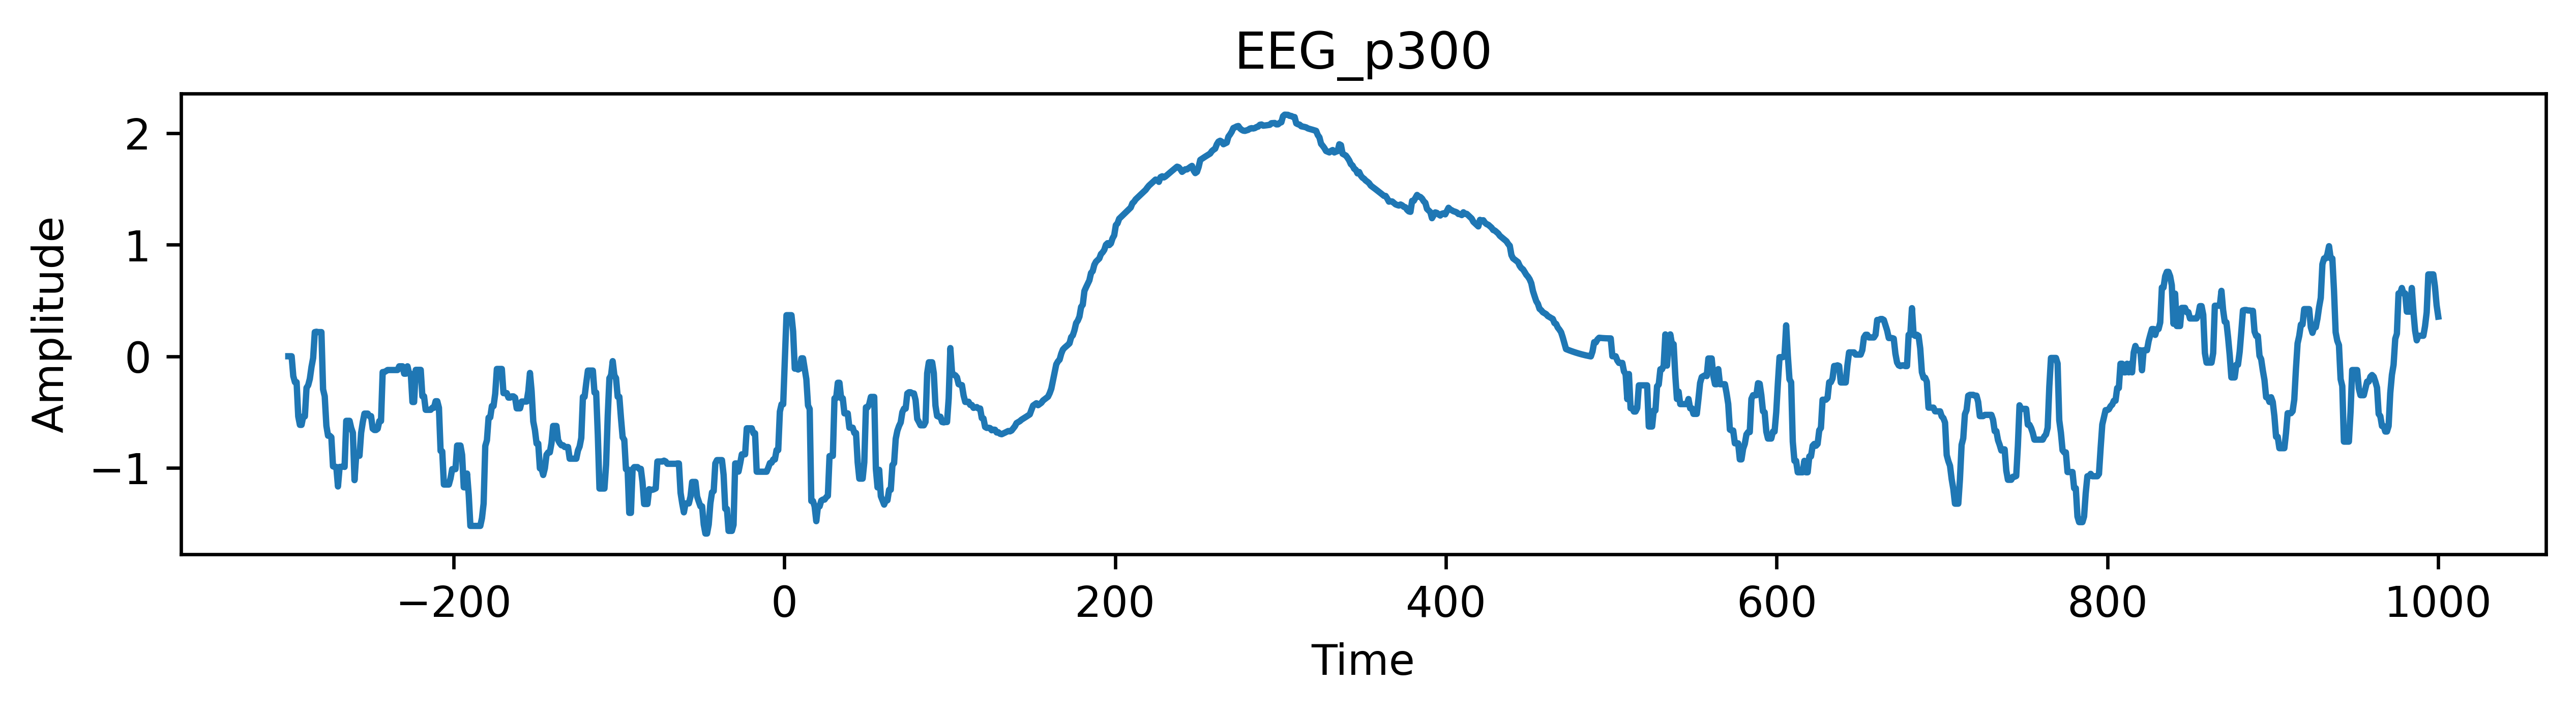

In [22]:
# 定义窗口长度
window_length = 400
# 构建汉明窗
hamming_window = np.hamming(window_length)

p_wave = hamming_window*2 
# 生成1000个样本的粉红噪声
pinkNoise = generate_pink_noise(1300)
pinknoise = pinkNoise*2

s1 = medfilt(pinknoise[0:400], kernel_size=7)
s2 = medfilt(pinknoise[400:800], kernel_size=55) + p_wave
s3 = medfilt(pinknoise[800:1300], kernel_size=7)
EEG_p300 = np.concatenate((s1,s2,s3))

# 生成示例数据
t = np.linspace(-300, 1000, 1300)

# 绘制汉明窗
plt.figure(figsize=(10,2),dpi = 600)
plt.subplot(1,2,1)
plt.plot(p_wave)
plt.xlabel('t')
plt.ylabel('Amplitude')
plt.title('Hamming Window')
plt.grid(True)
plt.subplot(1,2,2)
plt.plot(pinknoise)
plt.title('pinkNoise')
plt.grid(True)
plt.show()

# 绘制EEG
plt.figure(figsize=(10,2),dpi = 600)
plt.plot(t, EEG_p300)
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.title('EEG_p300')

### 3. 计算信号的近似熵、样本熵和模糊熵：窗长200，步长50，具体参数可以参考论文，我这是随便设的

In [23]:
wLength = 200  # 窗长
step_size = 50  # 移动步长
signal_length = len(EEG_p300)
coverage_length = wLength - 1  # 每次移动窗口可以覆盖的信号长度
num_windows = (signal_length - coverage_length) // step_size  # 可以进行的移动次数

apEnA = []  # 近似熵
saEnA = []  # 样本熵
fuEnA = []  # 模糊熵
for i in range(num_windows):
    data = EEG_p300[i*50: i*50+200]
    apEnA.append(ApEn(data, 2, 0.2))
    saEnA.append(SampEn(data, 2, 0.2))
    fuEnA.append(FuzzyEntopy(data, 2))

#### 3.1 近似熵

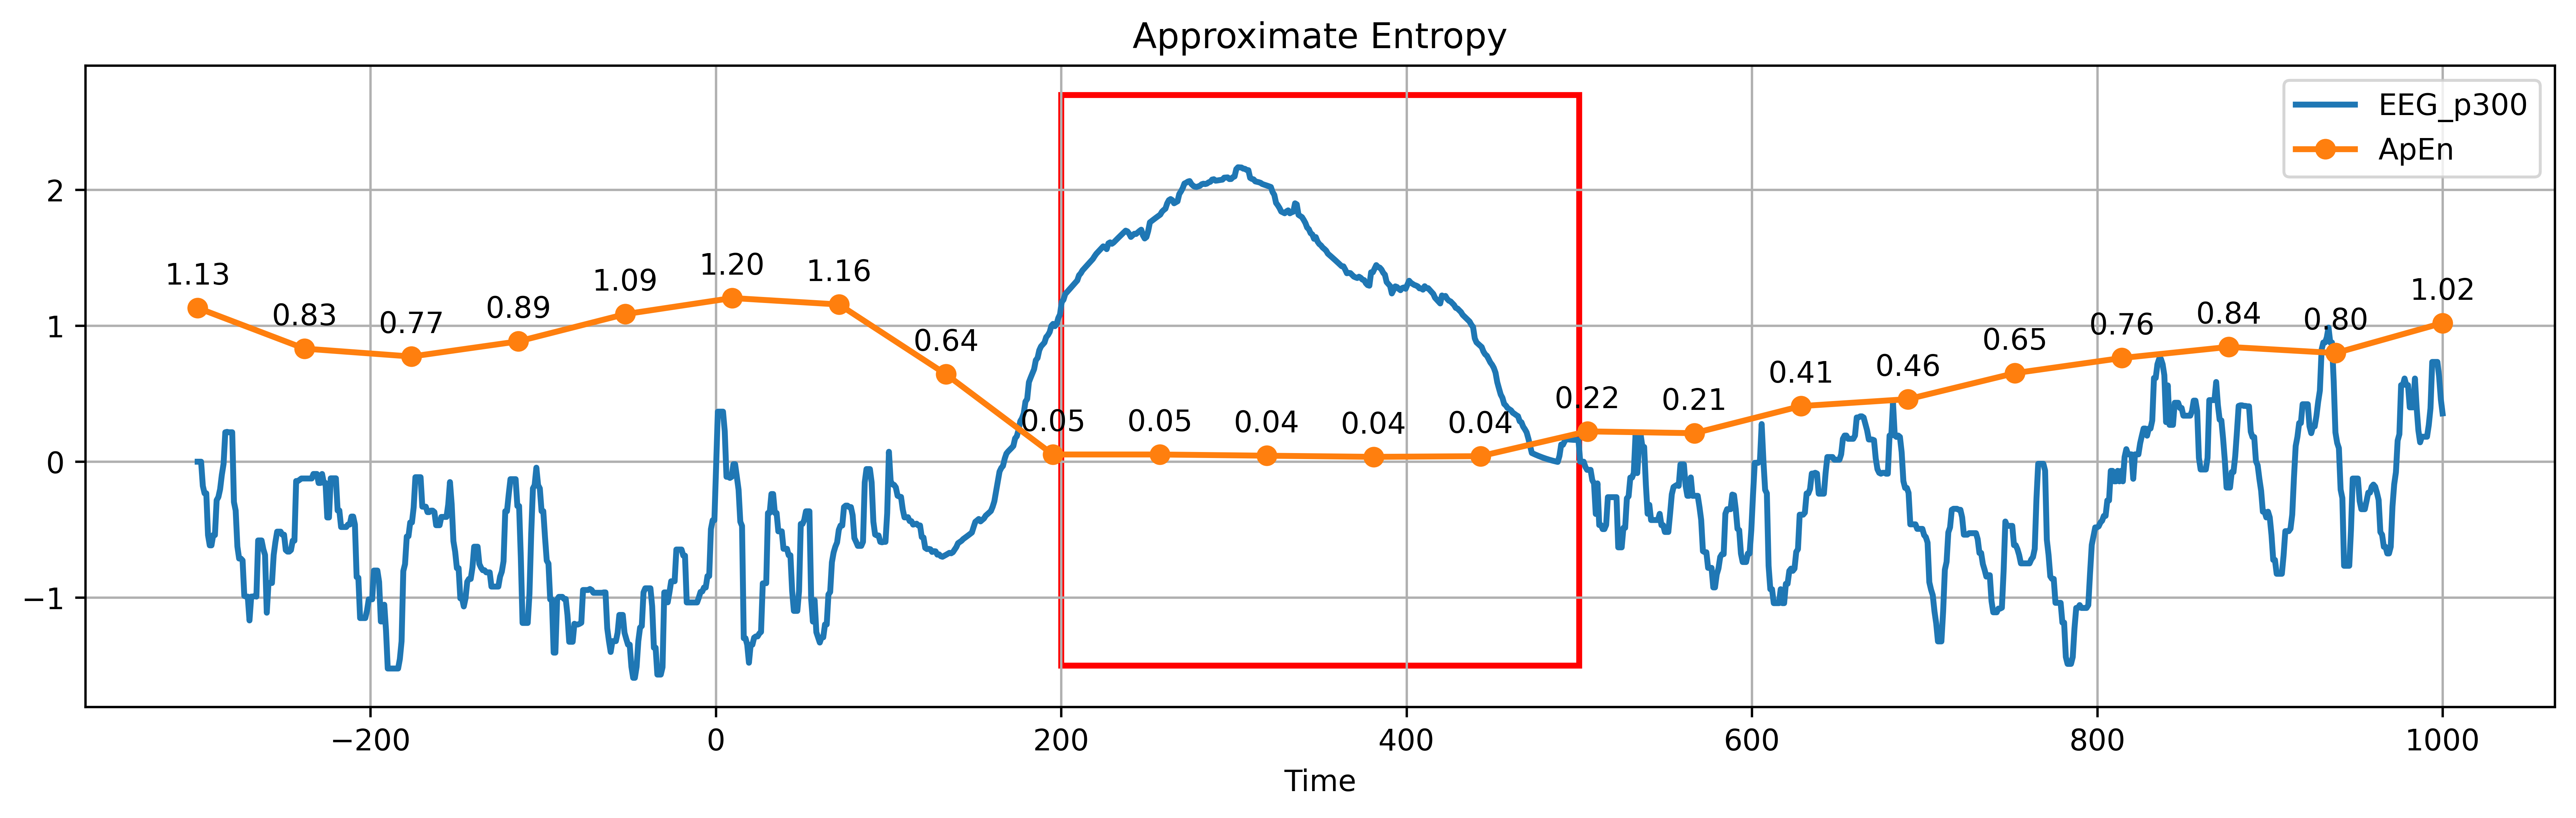

In [24]:
# 绘制原始信号与近似熵
fig, ax = plt.subplots(figsize=(15,4), dpi = 600)
t1 = np.linspace(-300,1000,num_windows)
plt.plot(t, EEG_p300, linewidth=2, label='EEG_p300')
plt.plot(t1, apEnA, linewidth=2, marker='o', label='ApEn')
# 添加矩形框
rect = Rectangle((200, -1.5), 300, 4.2, linewidth=2, edgecolor='r', facecolor='none')
ax.add_patch(rect)

plt.xlabel('Time')
plt.title('Approximate Entropy')
plt.legend()
plt.grid(True)
# 添加点的数值标签
for i in range(len(apEnA)):
    plt.annotate(f'{apEnA[i]:.2f}', (t1[i], apEnA[i]), textcoords="offset points", xytext=(0,8), ha='center')
plt.savefig('fig//ApEn.jpg')
plt.show()

#### 3.2 样本熵

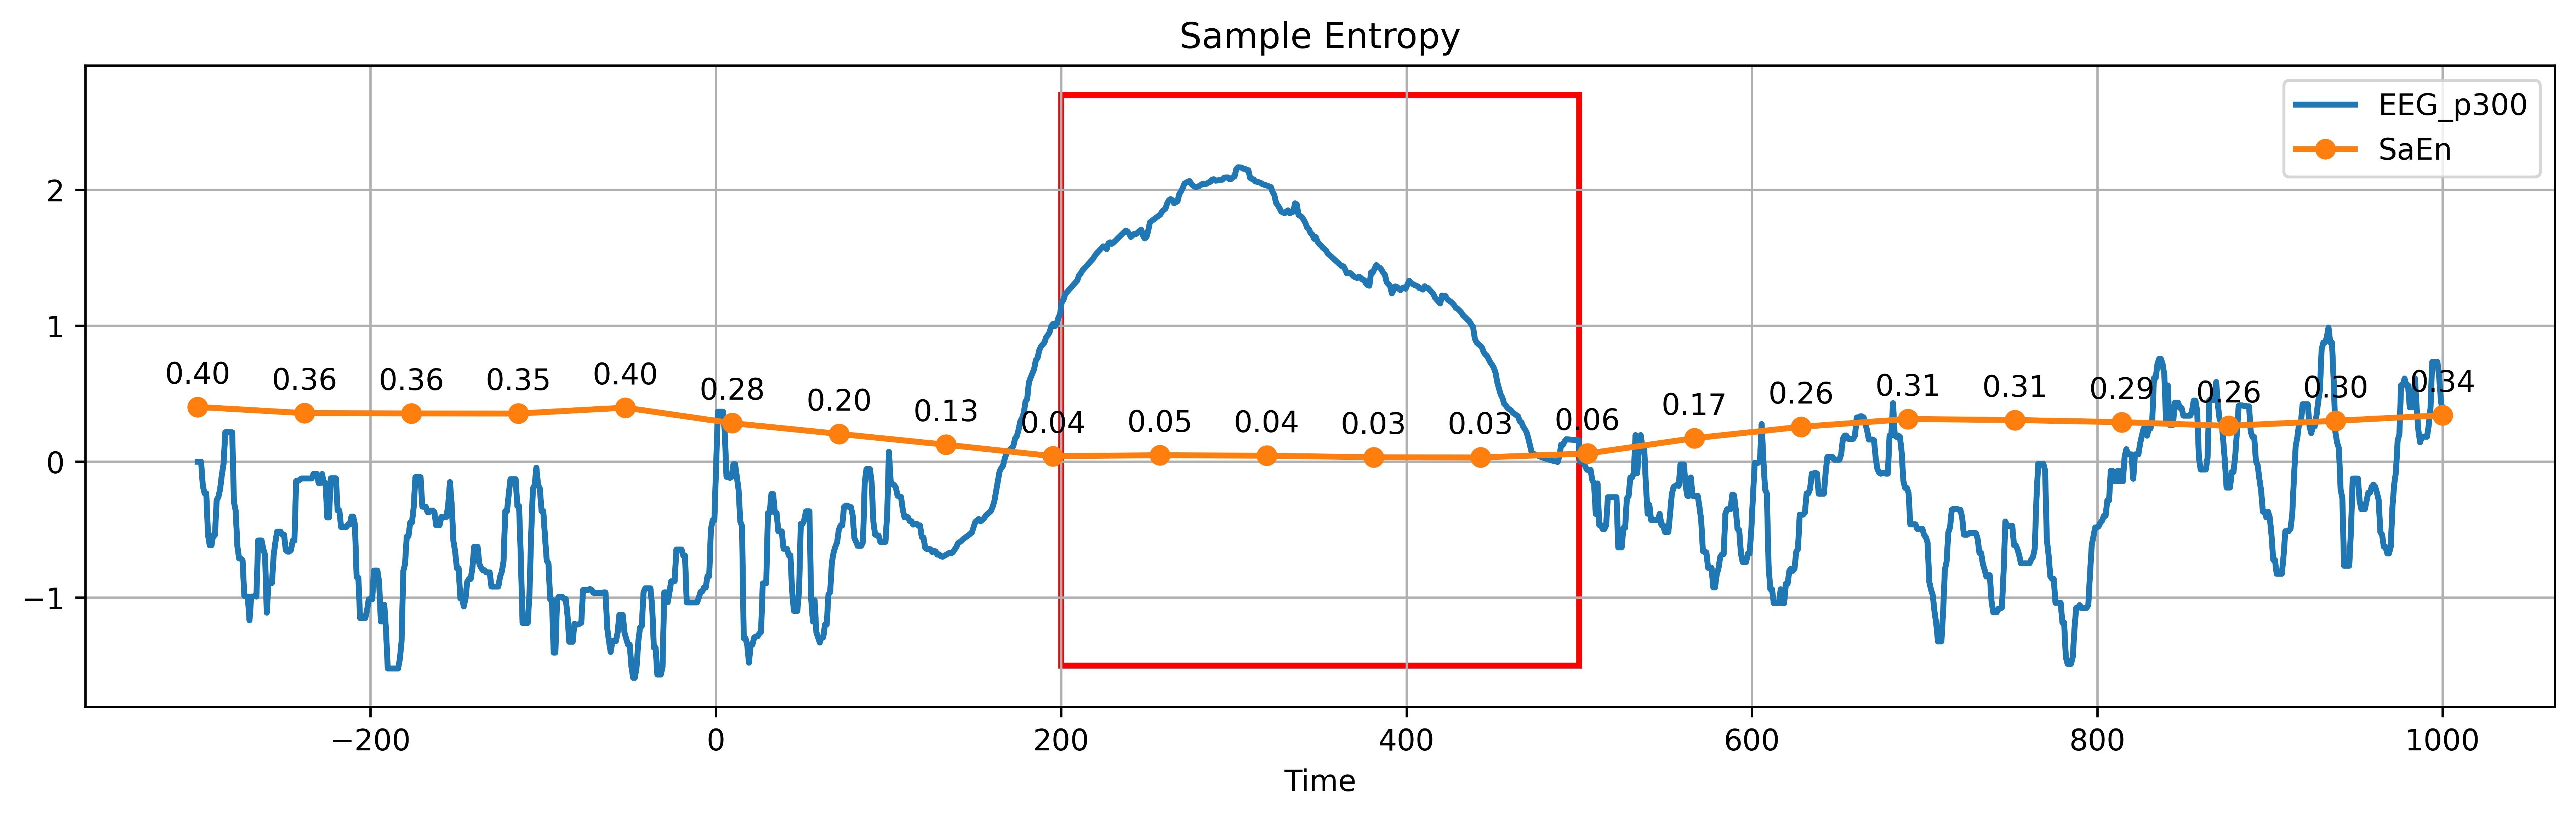

In [25]:
# 绘制原始信号与近似熵
fig, ax = plt.subplots(figsize=(15,4), dpi = 600)
t1 = np.linspace(-300,1000,num_windows)
plt.plot(t, EEG_p300, linewidth=2, label='EEG_p300')
plt.plot(t1, saEnA, linewidth=2, marker='o', label='SaEn')
# 添加矩形框
rect = Rectangle((200, -1.5), 300, 4.2, linewidth=2, edgecolor='r', facecolor='none')
ax.add_patch(rect)

plt.xlabel('Time')
plt.title('Sample Entropy')
plt.legend()
plt.grid(True)
# 添加点的数值标签
for i in range(len(saEnA)):
    plt.annotate(f'{saEnA[i]:.2f}', (t1[i], saEnA[i]), textcoords="offset points", xytext=(0,8), ha='center')
plt.savefig('fig//SaEn.jpg')
plt.show()

#### 3.3 模糊熵

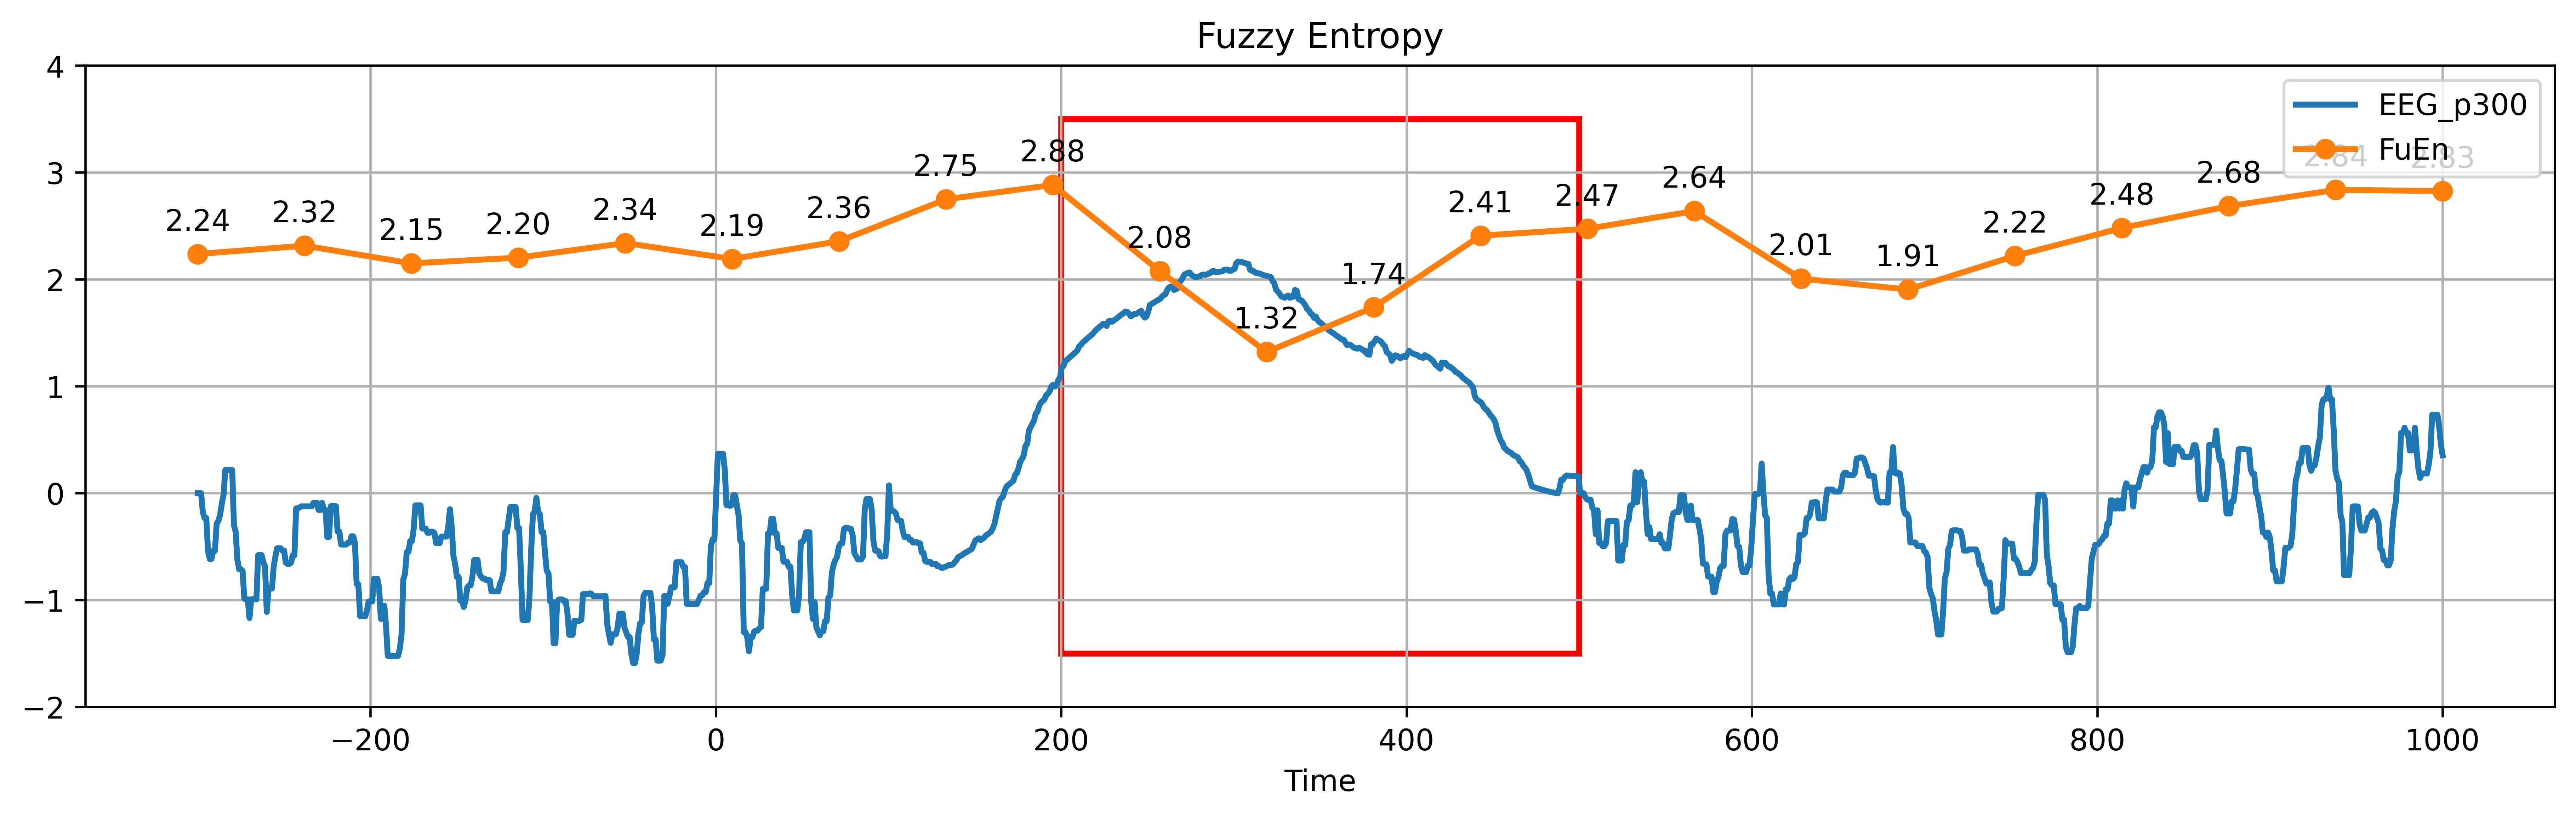

In [26]:
# 绘制原始信号与近似熵
fig, ax = plt.subplots(figsize=(15,4), dpi = 600)
t1 = np.linspace(-300,1000,num_windows)
plt.plot(t, EEG_p300, linewidth=2, label='EEG_p300')
plt.plot(t1, fuEnA, linewidth=2, marker='o', label='FuEn')
# 添加矩形框
rect = Rectangle((200, -1.5), 300, 5, linewidth=2, edgecolor='r', facecolor='none')
ax.add_patch(rect)

plt.xlabel('Time')
plt.title('Fuzzy Entropy')
plt.legend()
plt.grid(True)
# 添加点的数值标签
for i in range(len(fuEnA)):
    plt.annotate(f'{fuEnA[i]:.2f}', (t1[i], fuEnA[i]), textcoords="offset points", xytext=(0,8), ha='center')
plt.savefig('fig//FuEn.jpg')
plt.ylim([-2,4])
plt.show()